# Predictions

In [1]:
# Workaround for Firefox horizontal scroll for Dataframes
# https://github.com/jupyterlab/jupyterlab/issues/14625#issuecomment-1722137537
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [2]:
import sys
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

## Paths & Utils

In [3]:
# Avaialve datasets: CIFAR100, iNaturalist19, tieredImageNet
DATASET = "CIFAR100"

# Path
PATH_ROOT = Path("/Users/simo/Developer/master-thesis-code/")
PATH_EXPERIMENTS = PATH_ROOT / "experiments" / DATASET
PATH_DATASET = PATH_ROOT / "datasets" / "datasets" / DATASET
PATH_ENCODINGS = PATH_DATASET / "encodings"
PATH_RESULTS = PATH_ROOT / "evaluations" / "results" / DATASET

HIERARCHY = np.load(PATH_DATASET / "hierarchy" / "hierarchy.npy")

with open(PATH_DATASET / "classes" / "classes.txt") as f:
    CLASSES = [cls.strip() for cls in f.readlines()]


exps = pd.read_csv(
    PATH_RESULTS / "experiments.csv",
    index_col="id",
    converters={"encoding": lambda enc: PATH_ENCODINGS / enc},
    comment="#",
)

In [4]:
def hierarchy_to_lca(hierarchy: np.ndarray) -> np.ndarray:
    """
    Converts a hierarchy to a Least Common Ancestor (LCA) matrix.

    The LCA matrix is a square matrix where each element (i, j) represents
    the level of the least common ancestor for classes i and j.

    Args:
        hierarchy (np.array or torch.Tensor): A matrix where each row represents
            the ancestor hierarchy of a class.

    Returns:
        A square numpy array containing the LCA matrix.
    """
    # Number of hierarchy levels (L)
    # Number of finer classes (C)
    L, C = hierarchy.shape

    lca = np.full((C, C), L, dtype=int)

    for level in hierarchy:
        for row, coarse in zip(lca, level):
            for index, value in enumerate(level):
                if coarse == value:
                    row[index] -= 1
    return lca


def accuracy(
    predictions: np.ndarray,
    labels: np.ndarray,
    hierarchy: np.ndarray = HIERARCHY,
    level: int = 0,
    k: int = 1,
    reduction = np.mean,
) -> float:
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]
    labels = labels.reshape(-1, 1)
    corrects = np.any(
        hierarchy[level][top_k_predictions] == hierarchy[level][labels],
        axis=1,
    )
    return reduction(corrects)


def error_rate(
    predictions: np.ndarray,
    labels: np.ndarray,
    hierarchy: np.ndarray = HIERARCHY,
    level: int = 0,
    k: int = 1,
    reduction = np.mean,
) -> float:
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]
    labels = labels.reshape(-1, 1)
    wrongs = np.all(
        hierarchy[level][top_k_predictions] != hierarchy[level][labels],
        axis=1,
    )
    return reduction(wrongs)


def hier_dist_mistake(
    predictions: np.ndarray,
    labels: np.ndarray,
    hierarchy: np.ndarray = HIERARCHY,
    level: int = 0,
    k: int = 1,
) -> float:
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]
    labels = labels.reshape(-1, 1)
    wrongs = np.all(
        hierarchy[level][top_k_predictions] != hierarchy[level][labels],
        axis=1,
    )
    lca = hierarchy_to_lca(hierarchy[level:])
    lca_heights = lca[top_k_predictions[wrongs], labels[wrongs]]
    return np.mean(lca_heights)  # type: ignore


def hier_dist(
    predictions: np.ndarray,
    labels: np.ndarray,
    hierarchy: np.ndarray = HIERARCHY,
    level: int = 0,
    k: int = 1,
) -> float:
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]
    labels = labels.reshape(-1, 1)
    lca_heights = hierarchy_to_lca(hierarchy[level:])[top_k_predictions, labels]
    return np.mean(lca_heights)  # type: ignore


metrics_names = {
    # Predictions metrics
    "error_rate": "Error Rate",
    "hier_dist_mistake": "Hier. Dist. M.",
    "hier_dist": "Hier. Dist.",
    # Features metrics
    "silhouette": "Silhouette",
    "calinski_harabasz": "CH",
    "davies_bouldin": "DB",
    "sdbw": "SDbw",
}

In [5]:
def predictions_labels(exp, outputs, targets):
    # Load test results
    outputs = np.load(outputs)
    targets = np.load(targets)

    # For one-hot encoding targets are already class index (aka labels)
    # Convert back to one hot encoding to be consistent with others encondings
    if targets.shape[-1] == 1:
        labels = targets.squeeze().astype(int)
        targets = np.eye(HIERARCHY.shape[-1])[labels]

    # Select the encoder matrix
    encs = np.load(exps.loc[exp, "encoding"])

    # Normalize quantites
    outputs /= np.linalg.norm(outputs, axis=1, keepdims=True)
    targets /= np.linalg.norm(targets, axis=1, keepdims=True)
    encs /= np.linalg.norm(encs, axis=1, keepdims=True)

    # Calculate predictions and labels from outputs and targets
    predictions = outputs @ encs.T
    labels = (targets @ encs.T).argmax(axis=-1)

    return predictions, labels

In [6]:
def init(exps) -> pd.DataFrame:
    index = pd.Index(data=exps.index, dtype=str, name="experiments")
    columns = pd.MultiIndex.from_product(
        iterables=[
            range(len(HIERARCHY) - 1),
            ["error_rate", "hier_dist_mistake", "hier_dist"],
        ],
        names=["level", "metric"],
    )
    return pd.DataFrame(index=index, columns=columns, dtype=float)

def load(df, path) -> None:
    # no-attack: PATH_RESULTS / "predictions" / "metrics.pkl"
    # untar-attack: PATH_RESULTS / "predictions" / "_" / "metrics.pkl"
    # tar-attack: PATH_RESULTS / "predictions" / "apple" / "metrics.pkl"
    try:
        for idx, row in pd.read_pickle(path).iterrows():
            if idx in df.index:
                df.loc[idx] = row
    except FileNotFoundError:
        pass
    

def todo(df, path) -> pd.DataFrame:
    # no-attack: PATH_RESULTS / "predictions" / "metrics.pkl"
    # untar-attack: PATH_RESULTS / "predictions" / "_" / "metrics.pkl"
    # tar-attack: PATH_RESULTS / "predictions" / "apple" / "metrics.pkl"
    try:
        done = pd.read_pickle(path).index.intersection(df.index)
    except FileNotFoundError:
        done = pd.Index([], dtype=str)
    return df.loc[df.index.difference(done)]


def metrics(path_outputs, path_metrics):
    df = init(exps[exps["selected"]])
    load(df, PATH_RESULTS / "predictions" / path_metrics)
    df_todo = todo(df, PATH_RESULTS / "predictions" / path_metrics)
    pbar = tqdm(df_todo.iterrows(), total=len(df_todo), desc="Experiments")
    for exp, row in pbar:
        predictions, labels = predictions_labels(
            exp, 
            PATH_EXPERIMENTS / exp / "results"/ path_outputs, 
            PATH_EXPERIMENTS / exp / "results" / "targets.npy",
        )
        levels = trange(len(HIERARCHY) - 1, leave=False, desc=str(exp))
        for level in levels:
            df.loc[exp, (level, "error_rate")] = error_rate(
                predictions, labels, level=level, k=1
            )
            df.loc[exp, (level, "hier_dist_mistake")] = hier_dist_mistake(
                predictions, labels, level=level, k=1
            )
            df.loc[exp, (level, "hier_dist")] = hier_dist(
                predictions, labels, level=level, k=1
            )
    df.to_pickle(PATH_RESULTS / "predictions" / path_metrics)
    return df

## No Attack

In [7]:
df = metrics("outputs.npy", "metrics.pkl")
df.head()

Experiments: 0it [00:00, ?it/s]

level                                 0                              \
metric                       error_rate hier_dist_mistake hier_dist   
experiments                                                           
0606_1452_6e6081e4_xe-onehot     0.2822          2.445429    0.6901   
0707_0627_8bc6fb3e_xe-onehot     0.2783          2.420410    0.6736   
0707_1458_8bc6fb3e_xe-onehot     0.2838          2.453488    0.6963   
0709_1143_8bc6fb3e_xe-onehot     0.2841          2.448786    0.6957   
0709_1808_8bc6fb3e_xe-onehot     0.2743          2.421072    0.6641   

level                                 1                              \
metric                       error_rate hier_dist_mistake hier_dist   
experiments                                                           
0606_1452_6e6081e4_xe-onehot     0.1845          2.210840    0.4079   
0707_0627_8bc6fb3e_xe-onehot     0.1806          2.188815    0.3953   
0707_1458_8bc6fb3e_xe-onehot     0.1868          2.208244    0.4125   
0709_1143_8bc6fb3e_xe-onehot     0.1854          2.220065    0.4116   
0709_1808_8bc6fb3e_xe-onehot     0.1772          2.199774    0.3898   

level                                 2                              \
metric                       error_rate hier_dist_mistake hier_dist   
experiments                                                           
0606_1452_6e6081e4_xe-onehot     0.1203          1.857024    0.2234   
0707_0627_8bc6fb3e_xe-onehot     0.1163          1.846088    0.2147   
0707_1458_8bc6fb3e_xe-onehot     0.1251          1.804157    0.2257   
0709_1143_8bc6fb3e_xe-onehot     0.1207          1.874068    0.2262   
0709_1808_8bc6fb3e_xe-onehot     0.1159          1.834340    0.2126   

level                                 3                              
metric                       error_rate hier_dist_mistake hier_dist  
experiments                                                          
0606_1452_6e6081e4_xe-onehot     0.0609          1.692939    0.1031  
0707_0627_8bc6fb3e_xe-onehot     0.0578          1.702422    0.0984  
0707_1458_8bc6fb3e_xe-onehot     0.0602          1.671096    0.1006  
0709_1143_8bc6fb3e_xe-onehot     0.0625          1.688000    0.1055  
0709_1808_8bc6fb3e_xe-onehot     0.0569          1.699473    0.0967

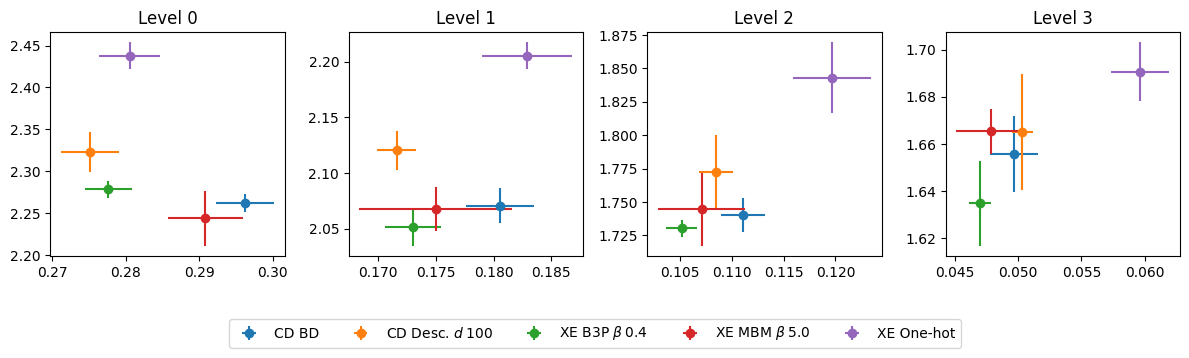

In [8]:
# Set those according to number of level in hierarchy
NROWS = 1
NCOLS = 4


plt.style.use('default')
figsize = (3 * NCOLS, 3 * NROWS)
fig, axs = plt.subplots(
    nrows=NROWS,
    ncols=NCOLS,
    figsize=figsize,
)

for lvl, ax in enumerate(axs):
    for name, runs  in df.groupby(exps["tex"]):
        ax.errorbar(
            runs.mean()[lvl, "error_rate"],
            runs.mean()[lvl, "hier_dist_mistake"],
            xerr=runs.std()[lvl, "error_rate"],
            yerr=runs.std()[lvl, "hier_dist_mistake"],
            fmt='o',
            label=name, # TODO use tex name
        )
    ax.set_title(f"Level {lvl}")

fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower center',
    handles=handles,
    labels=labels,
    bbox_to_anchor=(0.5, -0.2),
    ncol=len(df),
)

plt.show()

## Untargeted Attack

In [9]:
epsilons = [.00001, .0001, .001, 0.01, .1]

dfs = [
    (eps, metrics(f"_/outputs-{eps:.5f}.npy", f"_/metrics-{eps:.5f}.pkl"))
    for eps in epsilons
]
dfs.insert(0, (0, df))

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

### Hier. Dist. Mistake vs Error Rate

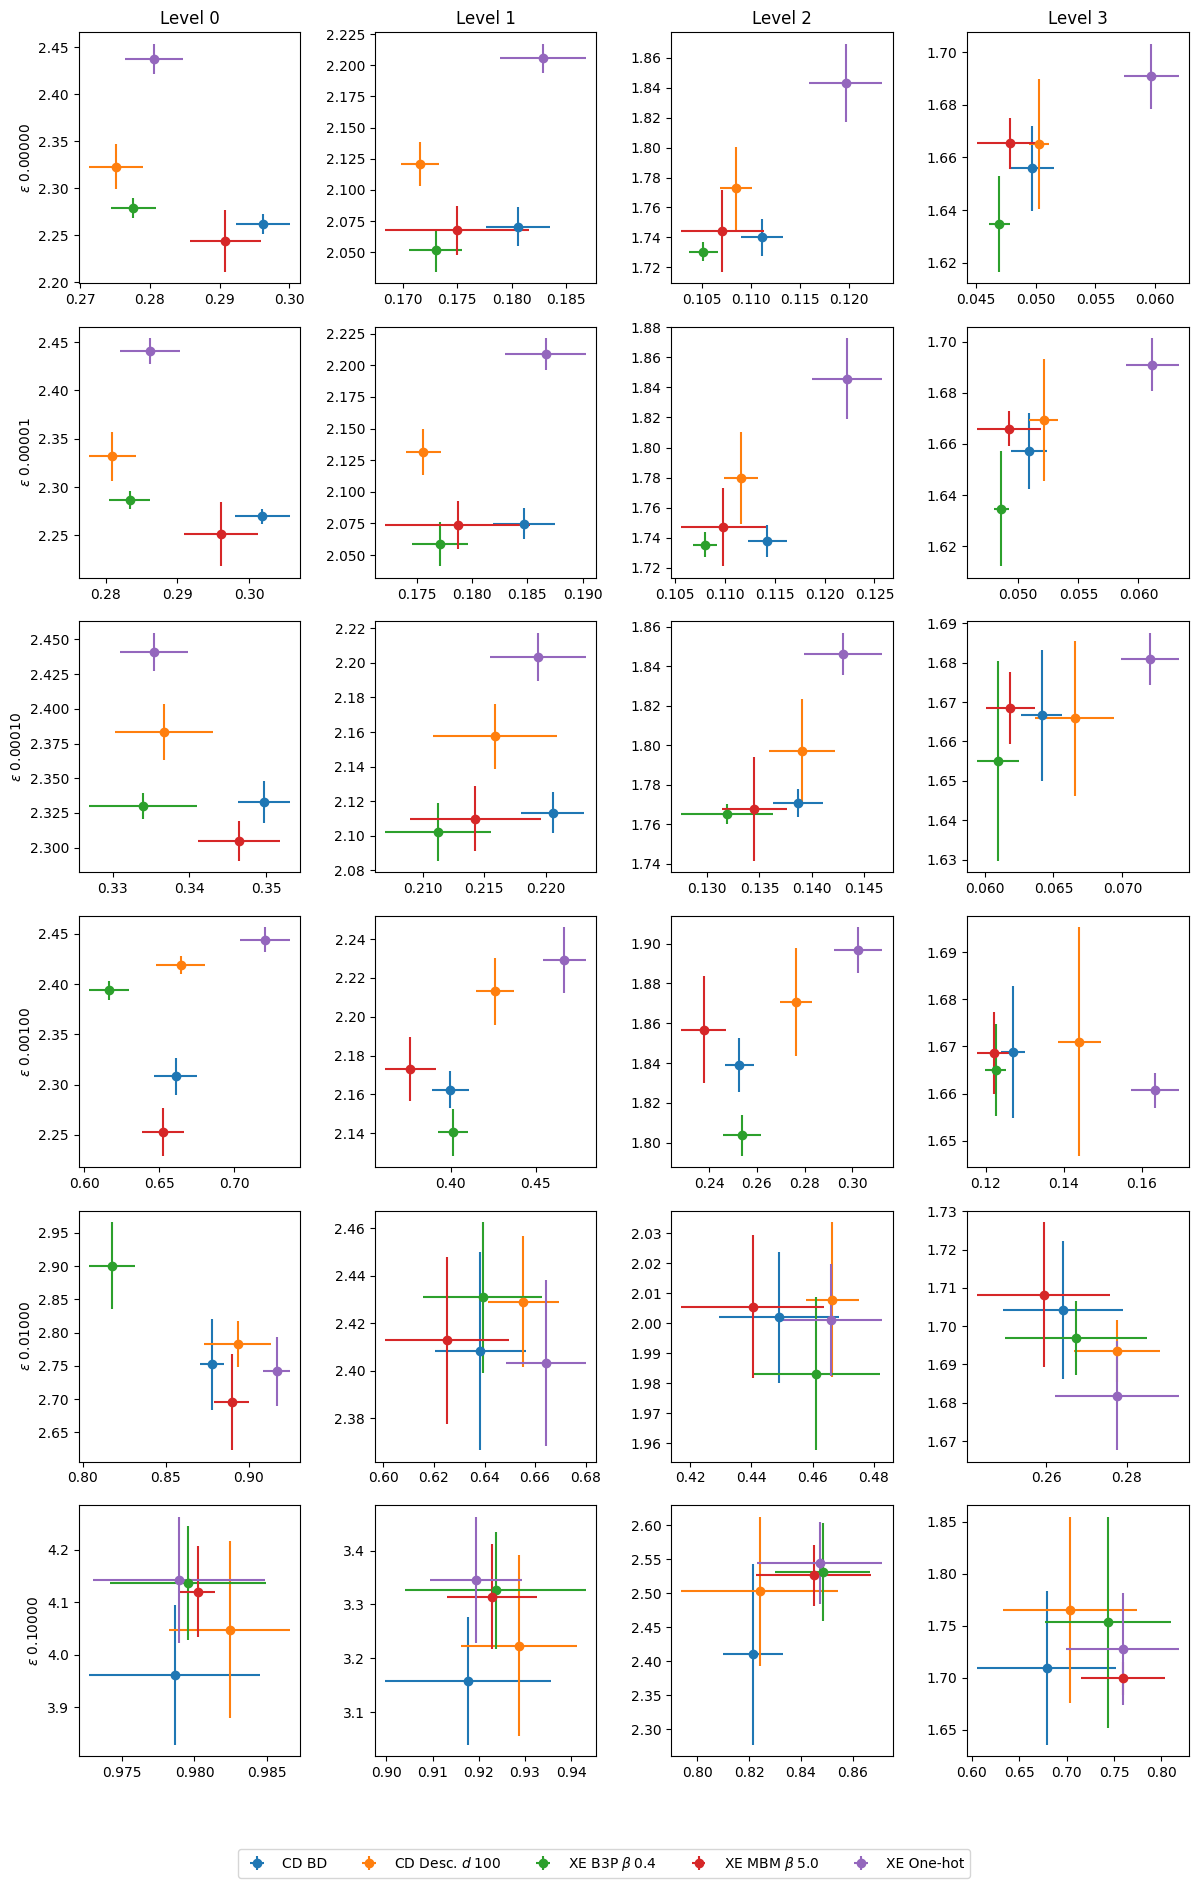

In [10]:
# Set those according to number of level in hierarchy
NROWS = len(dfs)
NCOLS = 4


plt.style.use('default')
figsize = (3 * NCOLS, 3 * NROWS)
fig, axs = plt.subplots(
    nrows=NROWS,
    ncols=NCOLS,
    figsize=figsize,
)

for i, (eps, df) in enumerate(dfs):
    for lvl, _ in enumerate(HIERARCHY[:-1]):
        ax = axs[i, lvl]
        for name, runs  in df.groupby(exps["tex"]):
            ax.errorbar(
                runs.mean()[lvl, "error_rate"],
                runs.mean()[lvl, "hier_dist_mistake"],
                xerr=runs.std()[lvl, "error_rate"],
                yerr=runs.std()[lvl, "hier_dist_mistake"],
                fmt='o',
                label=name, # TODO use tex name
            )
        
        if i == 0:
            ax.set_title(f"Level {lvl}")

        if lvl == 0:
            ax.set_ylabel(rf"$\epsilon$ {eps:.5f}")

fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower center',
    handles=handles,
    labels=labels,
    bbox_to_anchor=(0.5, -0.2/4),
    ncol=len(df),
)


plt.show()

### Error Rate - Epsilon

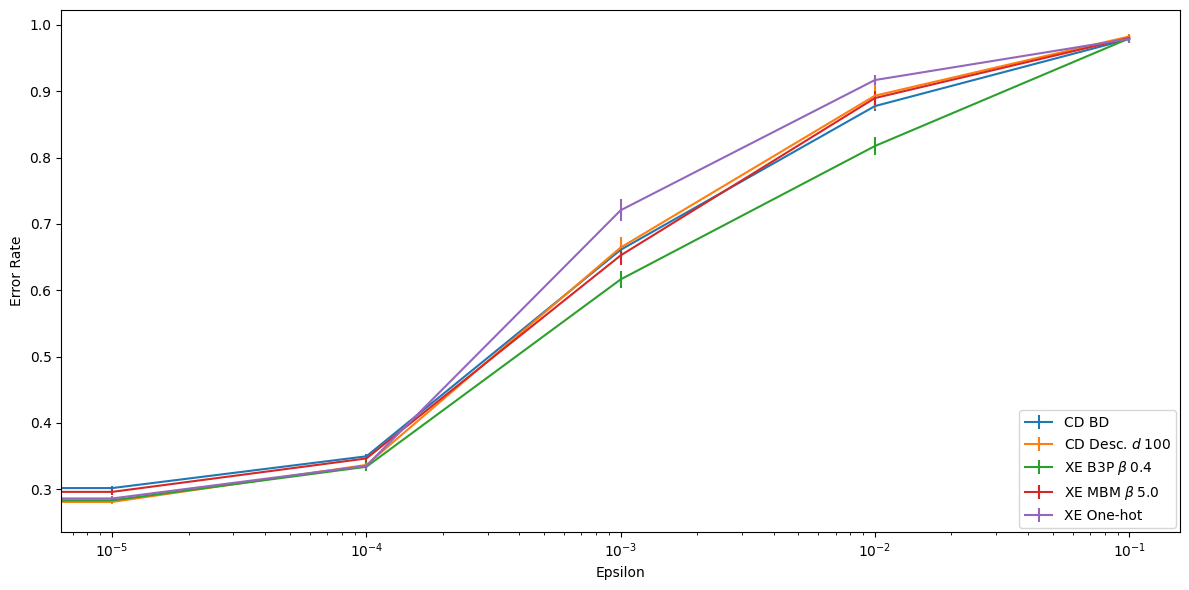

In [11]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "error_rate"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Error Rate')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower right',
    handles=handles,
    bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("err-eps.png")
plt.show()

### Hier. Dist. Mistake - Epsilon

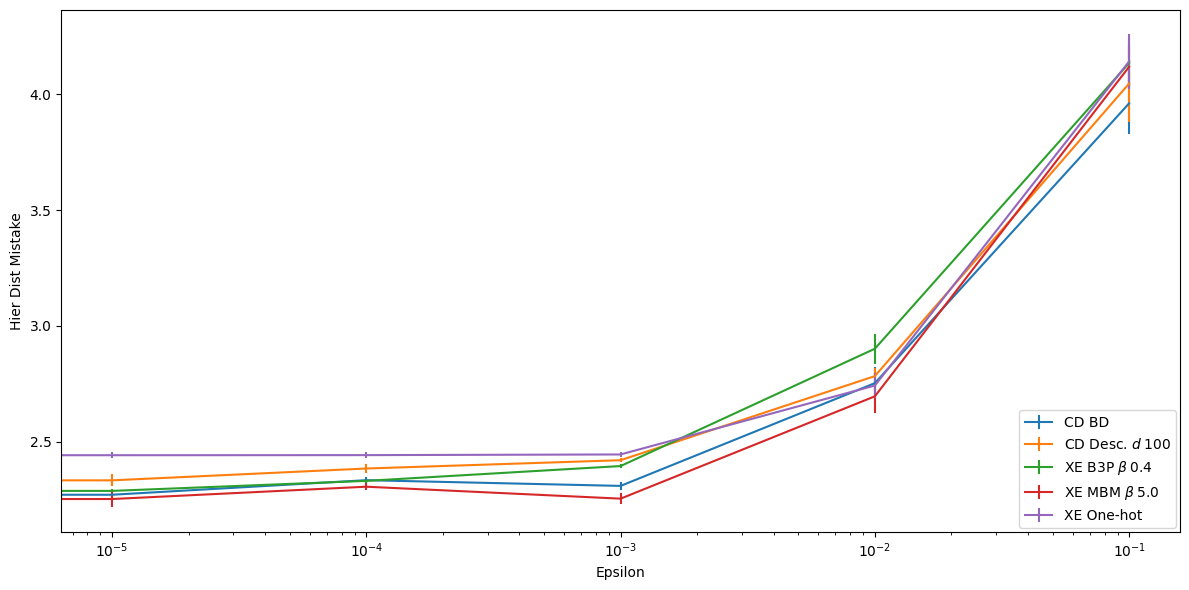

In [12]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "hier_dist_mistake"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Hier Dist Mistake')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower right',
    handles=handles,
    bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("ms-eps.png")
plt.show()

### Hier Dist. - Epsilon

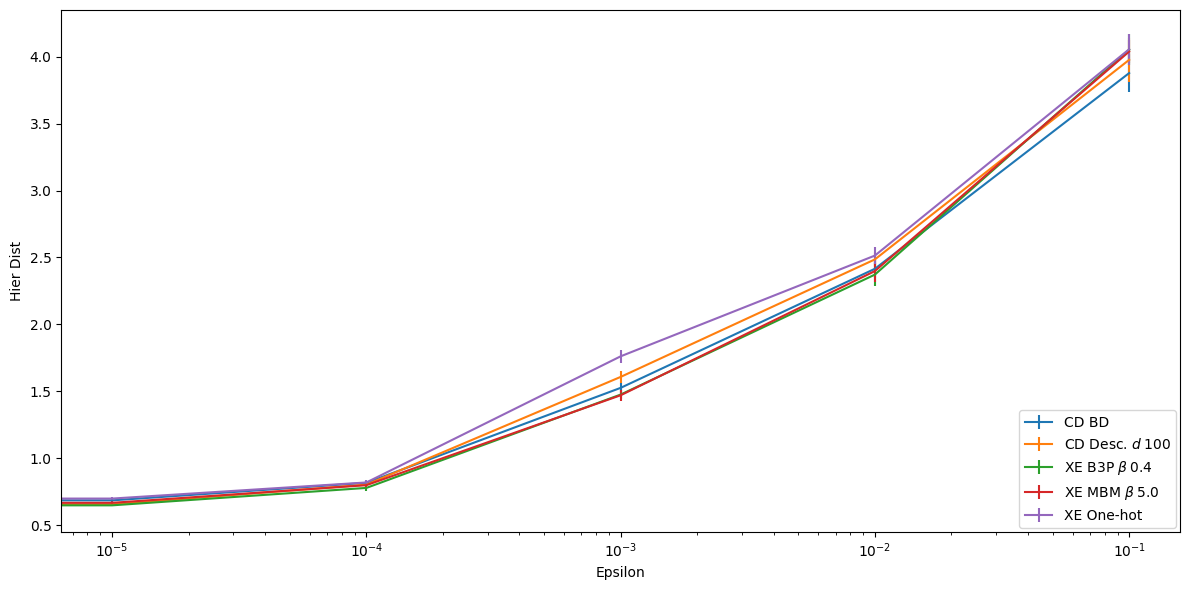

In [13]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "hier_dist"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Hier Dist')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower right',
    handles=handles,
    bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("hd-eps.png")
plt.show()

### Zoom [1e-2, 1e-4]

In [14]:
epsilons = [0.0001, 0.00021544, 0.00046416, 0.001, 0.00215443, 0.00464159, 0.01]

dfs = [
    (eps, metrics(f"_/outputs-{eps:.8f}.npy", f"_/metrics-{eps:.8f}.pkl"))
    for eps in epsilons
]
dfs.insert(0, (0, df))

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

Experiments: 0it [00:00, ?it/s]

#### Error Rate - Epsilon

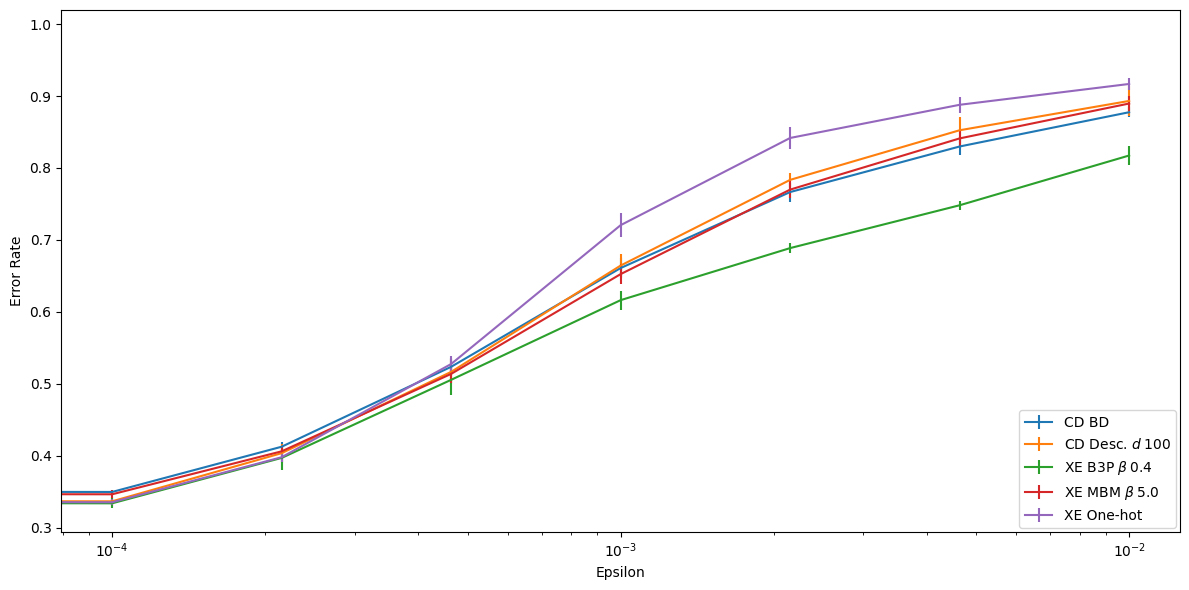

In [15]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "error_rate"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Error Rate')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower right',
    handles=handles,
    bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("err-eps.png")
plt.show()

#### Hier. Dist. Mistake - Epsilon

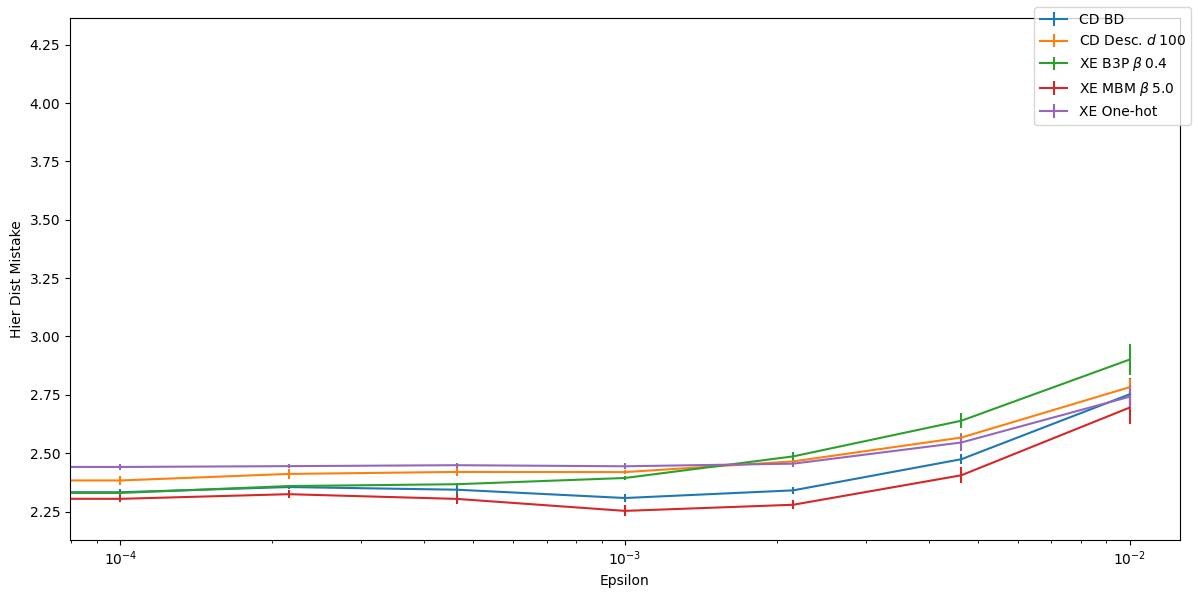

In [16]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "hier_dist_mistake"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Hier Dist Mistake')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    #loc='lower right',
    handles=handles,
    #bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("ms-eps.png")
plt.show()

#### Dist. Mistake - Epsilon

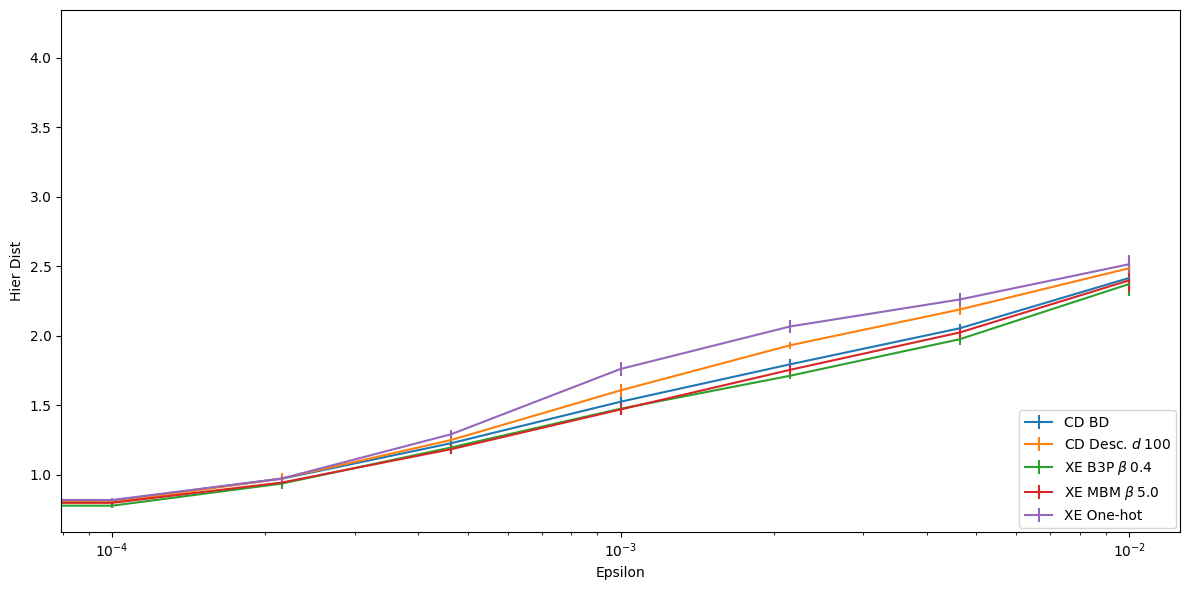

In [17]:
plt.style.use('default')
figsize = (12, 6)
fig, ax = plt.subplots(figsize=figsize)


means = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}
stds = {name: [] for name, runs  in dfs[0][1].groupby(exps["tex"])}

for eps, df in dfs:
    lvl = 0
    metric = "hier_dist"
    for name, runs  in df.groupby(exps["tex"]):
        means[name].append(runs.mean()[lvl, metric])
        stds[name].append(runs.std()[lvl, metric])

for name in means:
    ax.errorbar(
        [eps for eps, _ in dfs],
        means[name],
        yerr=stds[name],
        label=name,
    )

ax.set_xscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Hier Dist')
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    loc='lower right',
    handles=handles,
    bbox_to_anchor=(0.99, +0.1),
    labels=labels,
)
plt.savefig("hd-eps.png")
plt.show()

## Targeted Attack

In [18]:
def dfs_targeted(exp):
    
    df_num_samples = pd.DataFrame(index=CLASSES, columns=CLASSES)
    df_model_errors = pd.DataFrame(index=CLASSES, columns=CLASSES)
    df_attack_success = pd.DataFrame(index=CLASSES, columns=CLASSES)
    
    for i, attack_target in enumerate(tqdm(CLASSES, leave=False)):
        predictions, labels = predictions_labels(
            exp, 
            PATH_EXPERIMENTS / exp / "results"/  attack_target / "outputs-0.00100000.npy", 
            PATH_EXPERIMENTS / exp / "results" / "targets.npy",
        )
        errors = error_rate(predictions, labels, reduction = lambda x: x)
        successes = accuracy(predictions, np.array([i] * len(labels)), reduction = lambda x: x)
        for label, cls in enumerate(CLASSES):
            df_model_errors.loc[cls, attack_target] = sum(errors[labels == label])
            df_attack_success.loc[cls, attack_target] = sum(successes[labels == label])
    
        num_samples = Counter(labels)
        df_num_samples[attack_target] = [num_samples[cls] for cls in sorted(num_samples)]

    return df_num_samples, df_model_errors, df_attack_success

In [19]:
exps_selected = [
    "0707_1458_8bc6fb3e_xe-onehot",
    "0709_0441_f8d3b2ef_xe-b3p-beta0.4",
    "0805_1407_6bf28318_xe-mbm-beta5.0",
    "0712_0753_21b330e3_cd-barz-denzler",
    "0707_2336_02f6d919_cd-desc-pca-d100",
]
dists = np.arange(1, len(HIERARCHY) + 1, dtype=int)

dfs_model_errors = {}
dfs_attack_success = {}

for i, exp in enumerate(tqdm(exps_selected)):
    df_num_samples, df_model_errors, df_attack_success = dfs_targeted(exp)
    dfs_model_errors[exp] = df_model_errors
    dfs_attack_success[exp] = df_attack_success

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(               apple  aquarium_fish  baby  bear  beaver  bed  bee  beetle  \
 apple            100            100   100   100     100  100  100     100   
 aquarium_fish    100            100   100   100     100  100  100     100   
 baby             100            100   100   100     100  100  100     100   
 bear             100            100   100   100     100  100  100     100   
 beaver           100            100   100   100     100  100  100     100   
 ...              ...            ...   ...   ...     ...  ...  ...     ...   
 whale            100            100   100   100     100  100  100     100   
 willow_tree      100            100   100   100     100  100  100     100   
 wolf             100            100   100   100     100  100  100     100   
 woman            100            100   100   100     100  100  100     100   
 worm             100            100   100   100     100  100  100     100   
 
                bicycle  bottle  ...  train  trout  tulip  tur

In [27]:
# ROW: ground truth class
# COL: target class of adversarial attack
# VAL: number of errors, i.e. predicted cls != ground truth cls under attack towards target cls

# e.g ROW = apple, COL = baby, VAL = 10
# The model classify 10 "apple" images perturbetd to look like a "baby" as "not apple" 
dfs_model_errors["0707_1458_8bc6fb3e_xe-onehot"]

,apple,aquarium_fish,baby,bear,beaver,bed,bee,beetle,bicycle,bottle,...,train,trout,tulip,turtle,wardrobe,whale,willow_tree,wolf,woman,worm
apple,2,33,34,29,30,29,31,28,34,37,...,30,33,29,30,23,29,34,28,34,36
aquarium_fish,41,3,41,37,40,37,39,39,43,40,...,37,34,39,44,42,40,40,40,46,42
baby,63,66,11,76,72,65,75,67,61,71,...,75,64,73,76,70,65,78,77,70,61
bear,81,68,78,10,76,78,74,80,84,67,...,78,81,74,82,64,78,76,66,80,82
beaver,63,76,69,66,5,73,68,75,77,69,...,67,72,74,75,65,71,74,77,68,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whale,47,55,44,53,45,52,51,49,52,50,...,54,57,47,58,56,5,49,58,43,53
willow_tree,60,61,79,67,68,63,68,69,75,53,...,73,70,70,51,62,67,5,63,75,69
wolf,52,54,61,49,58,52,50,56,59,54,...,58,52,50,51,53,51,52,1,51,55
woman,69,71,76,70,82,64,69,71,76,69,...,74,77,61,68,66,63,67,71,13,61


In [28]:
# ROW: ground truth class
# COL: target class of adversarial attack
# VAL: number of successful attack, i.e. predicted cls == target cls under attack towards target cls.

# e.g ROW = apple, COL = baby, VAL = 3
# The model classify 3 "apple" images perturbetd to look like a "baby" as "baby".
# (Diag elements are useless)

dfs_attack_success["0707_1458_8bc6fb3e_xe-onehot"]

,apple,aquarium_fish,baby,bear,beaver,bed,bee,beetle,bicycle,bottle,...,train,trout,tulip,turtle,wardrobe,whale,willow_tree,wolf,woman,worm
apple,98,3,2,0,3,2,0,4,1,1,...,2,2,5,1,1,1,1,0,1,1
aquarium_fish,2,97,4,2,2,2,1,5,0,2,...,11,15,7,14,0,4,2,2,0,3
baby,6,5,89,5,9,4,6,5,3,3,...,2,2,4,2,3,2,0,1,36,6
bear,0,3,5,90,39,1,4,2,2,5,...,3,4,2,9,0,3,5,17,5,1
beaver,0,7,7,32,95,4,10,9,5,2,...,10,10,2,26,0,7,8,11,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whale,0,6,1,7,4,4,1,2,2,0,...,2,5,1,13,0,95,1,4,7,11
willow_tree,0,2,0,6,5,2,1,2,2,0,...,0,1,0,5,1,0,95,1,0,0
wolf,0,5,0,24,8,0,7,0,2,0,...,2,3,2,6,1,0,2,99,6,1
woman,1,2,28,11,7,5,6,2,3,4,...,2,6,6,6,2,6,0,3,87,3


In [29]:
# ROW: ground truth class
# COL: target class of adversarial attack
# VAL: number of sample in the ground truth class, i.e. same value repeted across cols

df_num_samples

,apple,aquarium_fish,baby,bear,beaver,bed,bee,beetle,bicycle,bottle,...,train,trout,tulip,turtle,wardrobe,whale,willow_tree,wolf,woman,worm
apple,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
aquarium_fish,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
baby,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
bear,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
beaver,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whale,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
willow_tree,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
wolf,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
woman,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [30]:
lca = hierarchy_to_lca(HIERARCHY)
lca

array([[0, 4, 4, ..., 4, 4, 4],
       [4, 0, 3, ..., 3, 3, 3],
       [4, 3, 0, ..., 2, 1, 3],
       ...,
       [4, 3, 2, ..., 0, 2, 3],
       [4, 3, 1, ..., 2, 0, 3],
       [4, 3, 3, ..., 3, 3, 0]])

### Distance vs (Models) Error Rate

  0%|          | 0/5 [00:00<?, ?it/s]

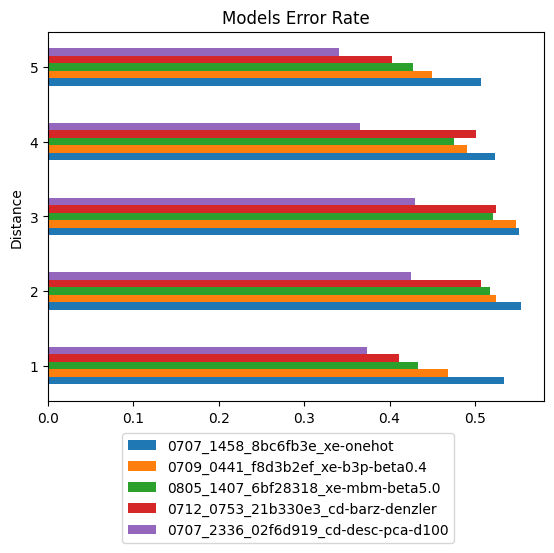

In [37]:
fig, ax = plt.subplots()
bar_height = 0.10

for i, exp in enumerate(tqdm(exps_selected)):
    
    df_model_errors = dfs_model_errors[exp]
    df_attack_success = dfs_attack_success[exp] 
    models_error_avgs = []
    attack_success_avgs = []
    
    for dist, _ in enumerate(HIERARCHY, 1):
        num_samples = sum(df_num_samples.values[lca == dist])
        models_error_avgs.append(sum(df_model_errors.values[lca == dist]) / num_samples)
    
    offset = bar_height * i
    rects = ax.barh(dists + offset, models_error_avgs, bar_height, label=exp)
    
ax.set_ylabel('Distance')
ax.set_title('Models Error Rate')


# Add legend
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
)
ax.set_yticks(dists + bar_height * 2, dists)

# Show the plot
plt.show()

### Distance vs (Attack) Success Rate

  0%|          | 0/5 [00:00<?, ?it/s]

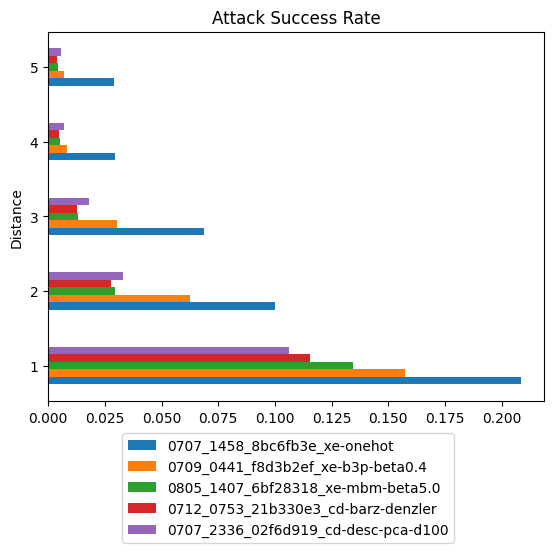

In [35]:
fig, ax = plt.subplots()
bar_height = 0.10

for i, exp in enumerate(tqdm(exps_selected)):
    
    df_model_errors = dfs_model_errors[exp]
    df_attack_success = dfs_attack_success[exp] 
    models_error_avgs = []
    attack_success_avgs = []
    
    for dist, _ in enumerate(HIERARCHY, 1):
        num_samples = sum(df_num_samples.values[lca == dist])
        attack_success_avgs.append(sum(df_attack_success.values[lca == dist]) / num_samples)
    
    offset = bar_height * i
    rects = ax.barh(dists + offset, attack_success_avgs, bar_height, label=exp)
    
ax.set_ylabel('Distance')
ax.set_title('Attack Success Rate')


# Add legend
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
)
ax.set_yticks(dists + bar_height * 2, dists)

# Show the plot
plt.show()